In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim 

In [2]:
import django
import platform

if platform.node() == "mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V

## Coherence

In [3]:
# Defining get_coherence
# Modified for parliament 
def get_coherence(run_id):
    stat = RunStats.objects.get(run_id=run_id)
    K = stat.K
    print("Getting coherence for {}".format(run_id))
    # obtain utterances in run_id 
    uts = pm.Utterance.objects.filter(search_matches=par_search_tei)
    # obtain paragraphs from utterances in queryset  
    texts = []
    for ut in uts:
        pars = ut.paragraph_set.all()
        texts.append(" ".join([x.text for x in pars]))

    sentences = [get_sentence_g(x) for x in texts]
    model = gensim.models.Word2Vec(sentences)
    print("Calculating model similarity)")
    validation_measure = WithinTopicMeasure(
        ModelSimilarity(model)
    )

    term_rankings = []

    topics = Topic.objects.filter(
        run_id=run_id
    )

    for topic in topics:
        term_ranking = list(Term.objects.filter(
            topicterm__topic=topic
        ).order_by(
            '-topicterm__score'
        ).values_list('title',flat=True)[:50])
        term_rankings.append(term_ranking)

    stat.coherence = validation_measure.evaluate_rankings(
        term_rankings
    )
    stat.save()
    print("Coherence obtained.")
    print(stat.coherence)
    return

In [4]:
user1, created =  User.objects.get_or_create(username='leey', email='lee@mcc-berlin.net')
print(user1)
user1.save()

leey


In [5]:
# simple search for utterances
par_search_tei, created = pm.Search.objects.get_or_create(
                title="Kohle tei utterance",
                text="kohle",
                creator=user1,
                document_source="GermaParlTEI",
                search_object_type=2)
par_search_tei.save()
if created:
    print("doing search")
do_search(par_search_tei.id)
print(par_search_tei.par_count)
print(par_search_tei.utterance_count)
print(par_search_tei.runstats_set.all())

3281 utterances with search kohle
35275
3281
35275
3281
<QuerySet [<RunStats: RunStats object (1069)>, <RunStats: RunStats object (1099)>, <RunStats: RunStats object (1070)>, <RunStats: RunStats object (1100)>, <RunStats: RunStats object (1080)>, <RunStats: RunStats object (1101)>, <RunStats: RunStats object (1081)>, <RunStats: RunStats object (1061)>, <RunStats: RunStats object (1062)>, <RunStats: RunStats object (1082)>, <RunStats: RunStats object (1093)>, <RunStats: RunStats object (1063)>, <RunStats: RunStats object (1083)>, <RunStats: RunStats object (1094)>, <RunStats: RunStats object (1045)>, <RunStats: RunStats object (1095)>, <RunStats: RunStats object (1046)>, <RunStats: RunStats object (1064)>, <RunStats: RunStats object (1084)>, <RunStats: RunStats object (1071)>, '...(remaining elements truncated)...']>


In [6]:
Ks = [20, 30, 40, 50] 
K_n = [10, 15, 25, 35, 45, 55, 60, 65, 70]
K_t = list(range(10,71,5))
search_word = "Kohle"

In [16]:
method="LD"
run_ids_ld = []
for K in K_t:
    run_ids_ld.append(RunStats.objects.filter(psearch__title="{} tei utterance".format(search_word), method=method, K=K)[0].run_id)

In [10]:
method_2="NM"
run_ids_nm = []
for K in K_t:
    run_ids_nm.append(RunStats.objects.filter(psearch__title="{} tei utterance".format(search_word), method=method_2, K=K)[0].run_id)

In [17]:
print(run_ids_ld)
print(run_ids_nm)

[1093, 1094, 1061, 1081, 1062, 1082, 1063, 1083, 1064, 1084, 1099, 1100, 1101]
[1028, 1066, 1029, 1067, 948, 1068, 1030, 1069, 1031, 1070, 1071, 1072, 1074]


In [18]:
for run_id in run_ids_ld:
    get_coherence(run_id)

Getting coherence for {}.format(run_id)
Calculating model similarity)
Coherence obtained.
0.14470069924596296
Getting coherence for {}.format(run_id)
Calculating model similarity)
Coherence obtained.
0.1422684149039815
Getting coherence for {}.format(run_id)
Calculating model similarity)
Coherence obtained.
0.13616589052104233
Getting coherence for {}.format(run_id)
Calculating model similarity)
Coherence obtained.
0.14880274056968903
Getting coherence for {}.format(run_id)
Calculating model similarity)
Coherence obtained.
0.1393756052505559
Getting coherence for {}.format(run_id)
Calculating model similarity)
Coherence obtained.
0.15143169828667927
Getting coherence for {}.format(run_id)
Calculating model similarity)
Coherence obtained.
0.1389856925571172
Getting coherence for {}.format(run_id)
Calculating model similarity)
Coherence obtained.
0.15445225545593455
Getting coherence for {}.format(run_id)
Calculating model similarity)
Coherence obtained.
0.15504430215414677
Getting coher

In [17]:
for run_id in run_ids_nm:
    get_coherence(run_id)

## Reconstruction

### Topic Model runs with reconstruction/perplexity 

In [7]:
# Perplexity
for K in Ks:
    run_tm(par_search_tei.id, K, method='LD')

creating term frequency matrix (5.174529314041138)
save terms to db (70.22257471084595)
running Latent Dirichlet Allocation (120.2374620437622)
saving document topic matrix to db (241.92612528800964)
topic model run done (253.1989984512329)
creating term frequency matrix (4.918903350830078)
save terms to db (70.76756739616394)
running Latent Dirichlet Allocation (120.34649586677551)
saving document topic matrix to db (275.44725251197815)
topic model run done (292.3270399570465)
creating term frequency matrix (5.028928518295288)
save terms to db (70.77572798728943)
running Latent Dirichlet Allocation (120.67517042160034)
saving document topic matrix to db (307.7472150325775)
topic model run done (332.18872332572937)
creating term frequency matrix (5.549048900604248)
save terms to db (70.84816074371338)
running Latent Dirichlet Allocation (120.98731064796448)
saving document topic matrix to db (354.0952191352844)
topic model run done (385.6611750125885)


In [7]:
# Perplexity
for K in Ks:
    run_tm(par_search_tei.id, K, method='LD')

creating term frequency matrix (5.174529314041138)
save terms to db (70.22257471084595)
running Latent Dirichlet Allocation (120.2374620437622)
saving document topic matrix to db (241.92612528800964)
topic model run done (253.1989984512329)
creating term frequency matrix (4.918903350830078)
save terms to db (70.76756739616394)
running Latent Dirichlet Allocation (120.34649586677551)
saving document topic matrix to db (275.44725251197815)
topic model run done (292.3270399570465)
creating term frequency matrix (5.028928518295288)
save terms to db (70.77572798728943)
running Latent Dirichlet Allocation (120.67517042160034)
saving document topic matrix to db (307.7472150325775)
topic model run done (332.18872332572937)
creating term frequency matrix (5.549048900604248)
save terms to db (70.84816074371338)
running Latent Dirichlet Allocation (120.98731064796448)
saving document topic matrix to db (354.0952191352844)
topic model run done (385.6611750125885)


In [5]:
# K_a
# max_iter and max_iteration confict, resolve tomorrow
import time
K_a = [25,35,45,55,60,65,70]
for i in K_a:
    run_tm.delay(par_search_tei.id, i, method='LD')
    time.sleep(5)

In [38]:
run_tm(par_search_tei.id, 10, method='LD')

creating term frequency matrix (7.583491563796997)
save terms to db (72.04360842704773)
running Latent Dirichlet Allocation (131.34997153282166)
saving document topic matrix to db (621.5513308048248)
topic model run done (628.7621054649353)


0

In [39]:
run_tm(par_search_tei.id, 15, method='LD')

creating term frequency matrix (5.514873027801514)
save terms to db (74.23382019996643)
running Latent Dirichlet Allocation (130.22170042991638)
saving document topic matrix to db (312.0520830154419)
topic model run done (322.44490480422974)


0

## Plots

### Coherence Plots 

In [7]:
# Style
sns.set_style('whitegrid')

In [31]:
coherences_ld = []
for run_id in run_ids_ld:
    coherences_ld.append(RunStats.objects.get(run_id=run_id).coherence)

In [15]:
coherences_ld_old = coherences_ld

In [22]:
coherences_nm = []
for run_id in run_ids_nm:
    coherences_nm.append(RunStats.objects.get(run_id=run_id).coherence)

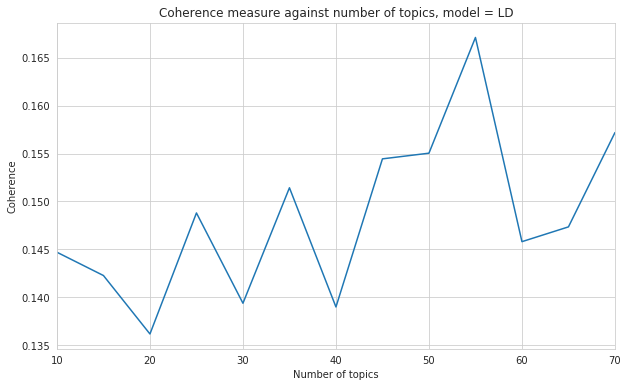

In [20]:
# LDA coherence plot
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(K_t, coherences_ld, ax = ax)
ax.set(xlim=(10,70),xlabel="Number of topics",ylabel="Coherence", title="Coherence measure against number of topics, model = {}".format(method))
plt.show()

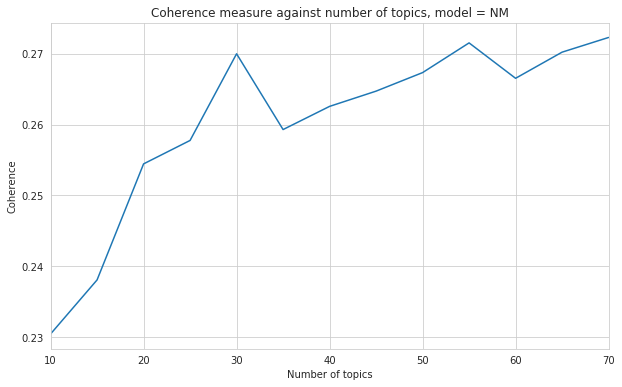

In [23]:
# NMF coherence plot 
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(K_t, coherences_nm, ax = ax)
ax.set(xlim=(10,70),xlabel="Number of topics",ylabel="Coherence", title="Coherence measure against number of topics, model = {}".format(method_2))
plt.show()

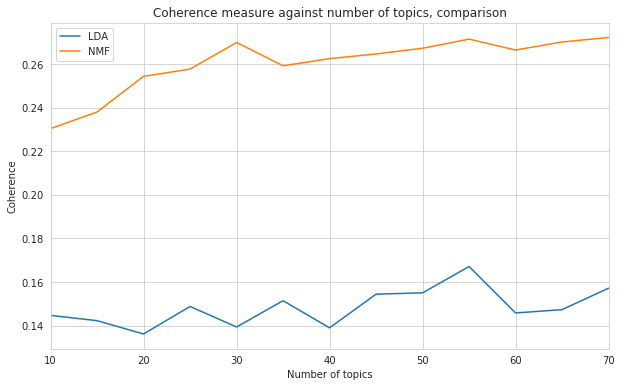

In [24]:
# Overlay both NMF and LDA
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(K_t, coherences_ld, ax = ax, label="LDA")
sns.lineplot(K_t, coherences_nm, ax = ax, label="NMF")
ax.set(xlim=(10,70),xlabel="Number of topics",ylabel="Coherence", title="Coherence measure against number of topics, comparison")
plt.legend
plt.show()

### Reconstruction Plots

In [32]:
run_ids_nm_rec = [1065, 1066, 1055, 1067, 1057, 1068, 1058, 1069, 1059, 1070, 1071, 1072, 1074]
rec_error_nm = []
rec_error_type = []

for run_id in run_ids_nm_rec:
    rec_error_nm.append(RunStats.objects.get(run_id=run_id).error)
    rec_error_type.append(RunStats.objects.get(run_id=run_id).errortype)

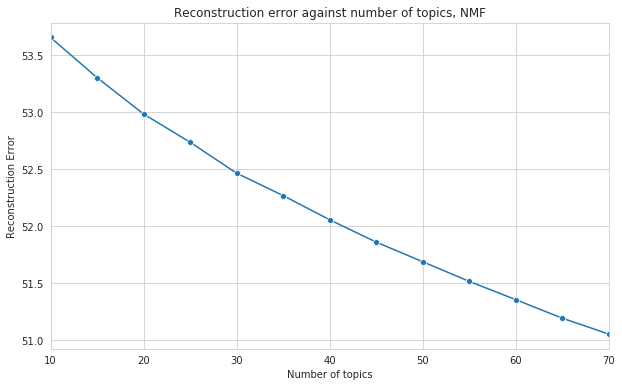

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(K_t, rec_error_nm, ax = ax, marker='o')
ax.set(xlim=(10,70),xlabel="Number of topics",ylabel="Reconstruction Error", title="Reconstruction error against number of topics, NMF")
plt.show()

In [32]:
run_ids_ld_err = [1093, 1094, 1061, 1095, 1062, 1096, 1063, 1097, 1064, 1098, 1099, 1100, 1101]
error_ld = []
error_type_ld = []

for run_id in run_ids_ld_err:
    error_ld.append(RunStats.objects.get(run_id=run_id).error)
    error_type_ld.append(RunStats.objects.get(run_id=run_id).error)

print(error_ld)    

[3799.61699242598, 4521.96448699206, 5426.96184161511, 6387.36292375439, 7938.29180776891, 9338.32166340836, 11664.1677990161, 13951.2875685489, 17120.0910748694, 21083.8731726414, 26012.0952995291, 31760.7507504218, 39101.6041612046]


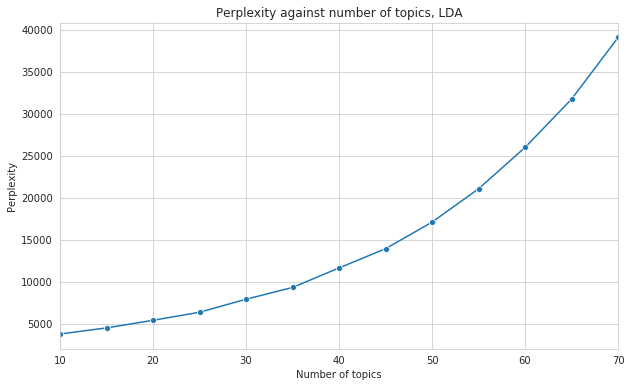

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(K_t, error_ld, ax = ax, marker='o')
ax.set(xlim=(10,70),xlabel="Number of topics",ylabel="Perplexity", title="Perplexity against number of topics, LDA")
plt.show()